In [5]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE,RBFNN,VAE_RBF,utils,manifolds,geodesics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from mpl_toolkits.mplot3d import Axes3D
from core import riemannian_metric
from core import custom_geodesics

# Download and preprocess data

In [2]:
# MNIST Dataset transformation
fashionmnist_transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] interval
    transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
])

# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class FilteredMNIST(Dataset):
    def __init__(self, mnist_dataset, labels):
        # Extract only the data with the specified labels
        self.data = [(img, label) for img, label in mnist_dataset if label in labels]
        self.imgs = [img for img, label in self.data]
        self.targets = [label for img, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
full_train_dataset = datasets.FashionMNIST(root='fashionmnist_data', train=True, transform=fashionmnist_transform, download=True)
print("Original size of the dataset: ", len(full_train_dataset))
filtered_labels = [0,1,7]
print("Filtered labels: ", filtered_labels)
train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
print("New size of the dataset: ", len(train_dataset))

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

Original size of the dataset:  60000
Filtered labels:  [0, 1, 7]
New size of the dataset:  18000


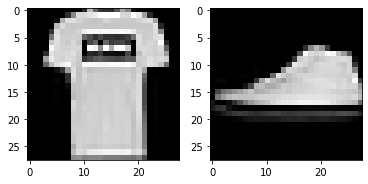

In [4]:
# show examples
fig,axs = plt.subplots(1,2)
axs[0].imshow(train_dataset[0][0].reshape(28, 28),cmap='gray')
axs[1].imshow(train_dataset[12][0].reshape(28, 28),cmap='gray')

# Train VAE RBFNN Model

## Initilize the VAE model

load a trained vae

In [3]:
# load the saved model
input_dim = train_dataset[0][0].shape[-1]
hidden_dims = [64, 32]
latent_dim = 2
hidden_activation = nn.Tanh()
encoder_output_mu_activation=nn.Identity()
encoder_output_logvar_activation=nn.Softplus()
decoder_output_mu_activation=nn.Sigmoid()
decoder_output_logvar_activation=nn.Softplus()

model_VAE = VAE.VAE(input_dim = input_dim, 
                hidden_dims = hidden_dims,
                latent_dim = latent_dim, 
                hidden_activation=hidden_activation, 
                encoder_output_mu_activation=encoder_output_mu_activation,
                encoder_output_logvar_activation=encoder_output_logvar_activation,
                decoder_output_mu_activation=decoder_output_mu_activation,
                decoder_output_logvar_activation=decoder_output_logvar_activation)

# create RBF network
k_rbf = 64
a = 2
zeta_rbf = 1e-6
model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# create VAE-RBF model
model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)

model_VAE_RBF.load_state_dict(torch.load('torch_models/VAE_RBFNN_fashionmnist.pt'))

model = model_VAE_RBF.VAE

In [4]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

## Sanity check of the VAE

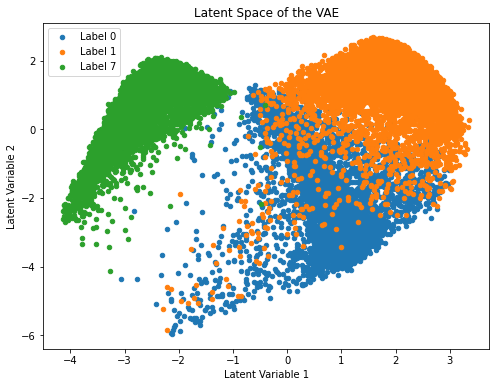

In [8]:
#%matplotlib widget # for 3d plot

# plot latent space
utils.plot_latent_space(latent_means,labels)

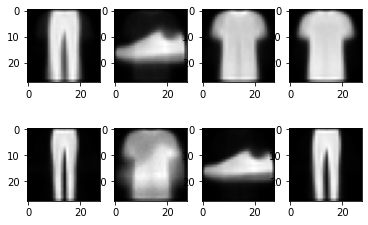

In [9]:
# display reconstructed output of the model
fig,axs = plt.subplots(2,4)
with torch.no_grad():
    for i in range(8):
        random_index = np.random.randint(0, len(train_dataset))
        pred = model(train_dataset[random_index][0].unsqueeze(0))[0] #just get mu_x
        axs[i//4,i%4].imshow(pred.reshape(28, 28),cmap='gray')

Text(0, 0.5, 'Latent Variable 2')

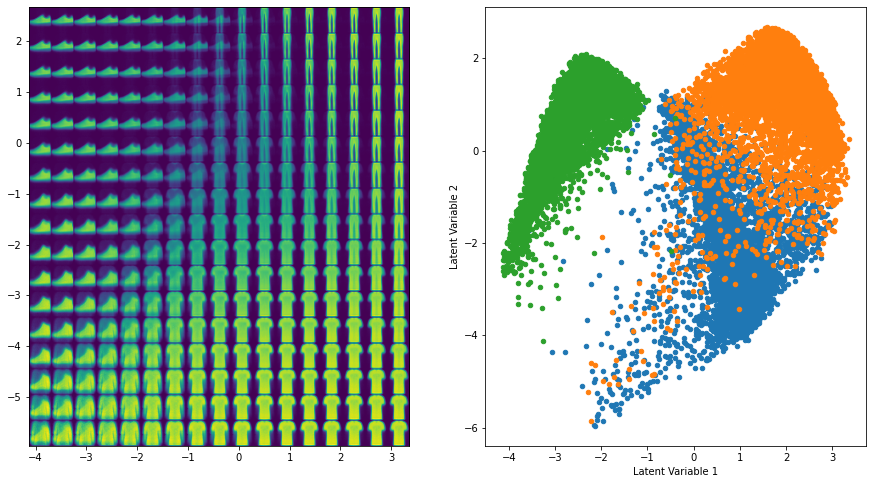

In [10]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]
n=17
w = 28
img = np.zeros((n*w, n*w))
for i, y in enumerate(np.linspace(min_y,max_y, n)):
    for j, x in enumerate(np.linspace(min_x,max_x, n)):
        z = torch.Tensor([[x, y]])
        x_hat = model.decode(z)[0]
        x_hat = x_hat.reshape(28, 28).detach().numpy()
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat

plt.figure(figsize=(15, 15))
plt.subplot(121, aspect='equal')
plt.imshow(img, extent=[min_x,max_x, min_y,max_y])
ax=plt.subplot(122, aspect='equal')
for label in np.unique(labels):
    points = latent_means[labels == label]
    ax.scatter(points[:, 0], points[:, 1], s=20, label=f'Label {label}')
ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')

note: with relu it a better diverse representation of the data (expected as we add more non linearity)

## Initialize the RBFN Model

### Create the RBF Network

Apply Kmeans to the latent space


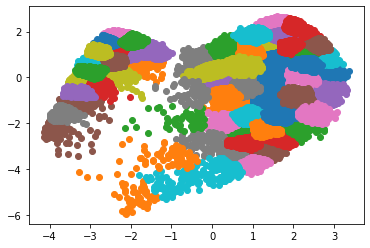

Compute the bandwidths for each centroids


In [107]:
# create RBF network
k_rbf = 64
a = 1.25
zeta_rbf = 1e-6
rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# apply kmeans to the means of the latent space
print("Apply Kmeans to the latent space")
plt.figure()
centers_rbf,centers_ids = rbfnn.fit_kmeans(latent_means.detach(),display=True)
# compute the bandwidths for each centroids
print("Compute the bandwidths for each centroids")
lambdas_k = rbfnn.compute_bandwidth(latent_means.detach())

## Train the RBF Network

[iter: 0/200] [objective loss: 4.051157]
[iter: 20/200] [objective loss: 1.356518]
[iter: 40/200] [objective loss: 0.736307]
[iter: 60/200] [objective loss: 0.505424]
[iter: 80/200] [objective loss: 0.425695]
[iter: 100/200] [objective loss: 0.396576]
[iter: 120/200] [objective loss: 0.386205]
[iter: 140/200] [objective loss: 0.387348]
[iter: 160/200] [objective loss: 0.379964]
[iter: 180/200] [objective loss: 0.379101]
[ELBO train: 0.377614]
Training finished


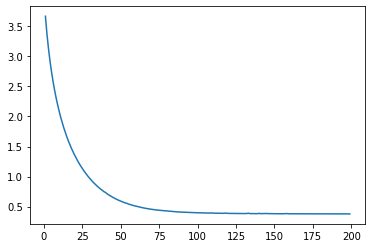

In [108]:
RBF_loss = []
nb_iters=200
optimizer_rbf = torch.optim.Adam(rbfnn.parameters(), lr=2e-4, weight_decay=1e-7)

for iter in range(nb_iters):
    # Initialize the losses
    train_loss = 0.0

    permutation = np.random.permutation(len(train_dataset))

    for i in range(0, len(train_dataset), batch_size):
        # Forward pass in the model
        indices = permutation[i:i + batch_size]
        # get previously computed latent means and logvars
        LOG_VAR_X = output_logvars[indices, :]
        MU_Z = latent_means[indices, :]
 
        # Regress the output of the variance network
        LOG_VAR_X_eval_RBF = -torch.log(rbfnn(MU_Z)) # = log(1/beta_psi(z)) to have logvar

        loss = torch.nn.MSELoss(reduction='mean')(LOG_VAR_X, LOG_VAR_X_eval_RBF)
             
        # Backward pass
        optimizer_rbf.zero_grad()
        loss.backward()
        optimizer_rbf.step()

        # Ensure positivity of the weights
        rbfnn.W_rbf.data.clamp_(min=1e-5)
        train_loss += loss.item()

    # Average loss for the iter
    average_iter_loss = train_loss / len(train_loader)
    RBF_loss.append(average_iter_loss)

    if iter % 20 == 0:
        print(f"[iter: {iter}/{nb_iters}] [objective loss: {average_iter_loss:.6f}]")
    
RBF_train = round(RBF_loss[-1],6)
print(f'[ELBO train: {RBF_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, nb_iters), RBF_loss[1:])
plt.show()

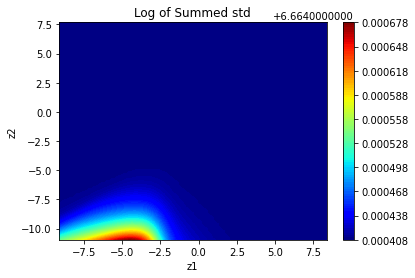

In [109]:
latent_means = latent_means.detach()
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]

# plot the latent space
n=100
offset=5
x = torch.linspace(min_x-offset,max_x+offset,n)
y = torch.linspace(min_y-offset,max_y+offset,n)
X,Y = torch.meshgrid(x,y)
grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

with torch.no_grad():
    logvar_x = model.decode(grid)[1]
    summed_logvar_x = torch.log(torch.sum(torch.exp(logvar_x/2),dim=1))
    #summed_logvar_x = (torch.sum((logvar_x),dim=1))
   
    
    summed_logvar_x = summed_logvar_x.reshape(X.shape)
    plt.figure()
    plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Log of Summed std')
    plt.show()

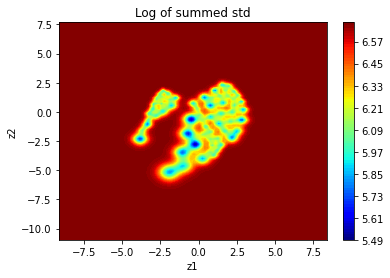

In [110]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]

# plot the latent space
n=100
offset=5
x = torch.linspace(min_x-offset,max_x+offset,n)
y = torch.linspace(min_y-offset,max_y+offset,n)
X,Y = torch.meshgrid(x,y)
grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

with torch.no_grad():
    logvar_x = rbfnn(grid)
    #summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
    summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
    summed_logvar_x = summed_logvar_x.reshape(X.shape)
    plt.figure()
    plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Log of summed std')
    plt.show()

In [9]:
from core import riemannian_metric
vae_rbf_model = VAE_RBF.VAE_RBF(model,rbfnn)
metric = riemannian_metric.Riemannian_metric(vae_rbf_model)
M_z = metric.compute_riemannian_metric(latent_means,var_rbfn=True)

# plot measure on latent space
latent_means_np = latent_means.detach().numpy()
z1min, z2min = latent_means_np.min(0) - 0.5
z1max, z2max = latent_means_np.max(0) + 0.5
fig, ax = plt.subplots(figsize=(8, 8))
offset=3

metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 100),vae_rbfn=True)

for label in np.unique(labels):
    points = latent_means.detach()[labels == label]
    ax.scatter(points[:, 0], points[:, 1], s=20, label=f'Label {label}',alpha=0.2)
plt.show()

NameError: name 'rbfnn' is not defined

# Save the trained models into a .pt

In [107]:
# combine both model into one torch module
vae_rbf_model = VAE_RBF.VAE_RBF(model,rbfnn)
torch.save(vae_rbf_model.state_dict(), 'torch_models/VAE_RBFNN_fashionmnistTEST.pt')

Apply Kmeans to the latent space


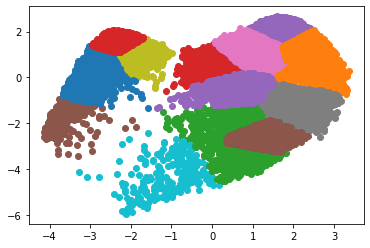

Compute the bandwidths for each centroids
[iter: 0/200] [objective loss: 2.561134]
[iter: 20/200] [objective loss: 1.263212]
[iter: 40/200] [objective loss: 0.839314]
[iter: 60/200] [objective loss: 0.611267]
[iter: 80/200] [objective loss: 0.476747]
[iter: 100/200] [objective loss: 0.396881]
[iter: 120/200] [objective loss: 0.346816]
[iter: 140/200] [objective loss: 0.315764]
[iter: 160/200] [objective loss: 0.300566]
[iter: 180/200] [objective loss: 0.290321]
[ELBO train: 0.286416]
Training finished


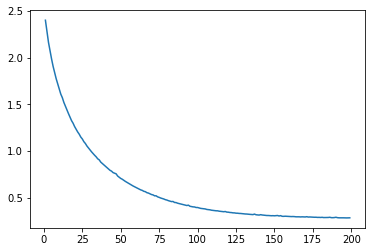

Apply Kmeans to the latent space


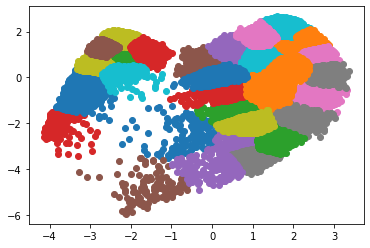

Compute the bandwidths for each centroids
[iter: 0/200] [objective loss: 2.350172]
[iter: 20/200] [objective loss: 1.149292]
[iter: 40/200] [objective loss: 0.749076]
[iter: 60/200] [objective loss: 0.536269]
[iter: 80/200] [objective loss: 0.410136]
[iter: 100/200] [objective loss: 0.334197]
[iter: 120/200] [objective loss: 0.287465]
[iter: 140/200] [objective loss: 0.264316]
[iter: 160/200] [objective loss: 0.250598]
[iter: 180/200] [objective loss: 0.237928]
[ELBO train: 0.233073]
Training finished


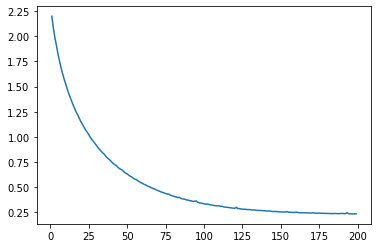

Apply Kmeans to the latent space


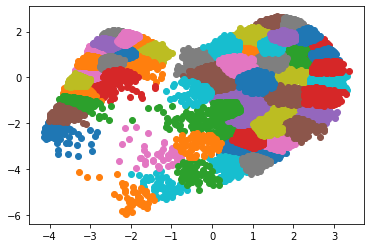

Compute the bandwidths for each centroids
[iter: 0/200] [objective loss: 1.991703]
[iter: 20/200] [objective loss: 0.957284]
[iter: 40/200] [objective loss: 0.607317]
[iter: 60/200] [objective loss: 0.429760]
[iter: 80/200] [objective loss: 0.320232]
[iter: 100/200] [objective loss: 0.262024]
[iter: 120/200] [objective loss: 0.227324]
[iter: 140/200] [objective loss: 0.207875]
[iter: 160/200] [objective loss: 0.198506]
[iter: 180/200] [objective loss: 0.192838]
[ELBO train: 0.190466]
Training finished


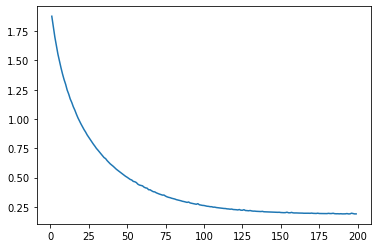

Apply Kmeans to the latent space


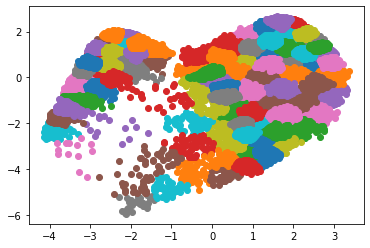

Compute the bandwidths for each centroids
[iter: 0/200] [objective loss: 1.927835]
[iter: 20/200] [objective loss: 0.924041]
[iter: 40/200] [objective loss: 0.570484]
[iter: 60/200] [objective loss: 0.385862]
[iter: 80/200] [objective loss: 0.282014]
[iter: 100/200] [objective loss: 0.221101]
[iter: 120/200] [objective loss: 0.185664]
[iter: 140/200] [objective loss: 0.165260]
[iter: 160/200] [objective loss: 0.154582]
[iter: 180/200] [objective loss: 0.149213]
[ELBO train: 0.146099]
Training finished


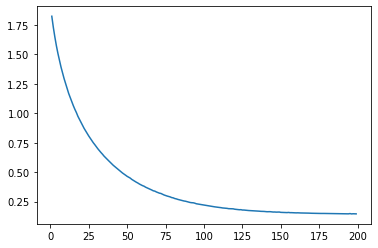

Apply Kmeans to the latent space


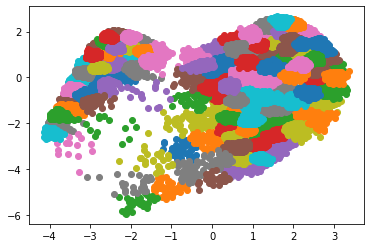

Compute the bandwidths for each centroids
[iter: 0/200] [objective loss: 1.933830]
[iter: 20/200] [objective loss: 0.935069]
[iter: 40/200] [objective loss: 0.579193]
[iter: 60/200] [objective loss: 0.390886]
[iter: 80/200] [objective loss: 0.280195]
[iter: 100/200] [objective loss: 0.215860]
[iter: 120/200] [objective loss: 0.177798]
[iter: 140/200] [objective loss: 0.156432]
[iter: 160/200] [objective loss: 0.143411]
[iter: 180/200] [objective loss: 0.136699]
[ELBO train: 0.132673]
Training finished


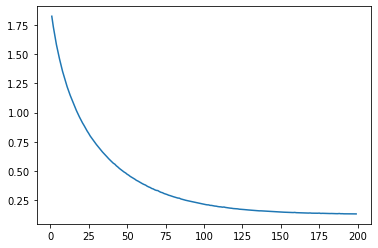

In [14]:
for k_rbf in [16,32,64,96,128]:
    # create RBF network
    a = 1.25
    zeta_rbf = 1e-6
    rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

    # apply kmeans to the means of the latent space
    print("Apply Kmeans to the latent space")
    plt.figure()
    centers_rbf,centers_ids = rbfnn.fit_kmeans(latent_means.detach(),display=True)
    # compute the bandwidths for each centroids
    print("Compute the bandwidths for each centroids")
    lambdas_k = rbfnn.compute_bandwidth(latent_means.detach())


    RBF_loss = []
    nb_iters=200
    optimizer_rbf = torch.optim.Adam(rbfnn.parameters(), lr=2e-4, weight_decay=1e-7)

    for iter in range(nb_iters):
        # Initialize the losses
        train_loss = 0.0

        permutation = np.random.permutation(len(train_dataset))

        for i in range(0, len(train_dataset), batch_size):
            # Forward pass in the model
            indices = permutation[i:i + batch_size]
            # get previously computed latent means and logvars
            LOG_VAR_X = output_logvars[indices, :]
            MU_Z = latent_means[indices, :]
    
            # Regress the output of the variance network
            LOG_VAR_X_eval_RBF = -torch.log(rbfnn(MU_Z)) # = log(1/beta_psi(z)) to have logvar

            loss = torch.nn.MSELoss(reduction='mean')(LOG_VAR_X, LOG_VAR_X_eval_RBF)
                
            # Backward pass
            optimizer_rbf.zero_grad()
            loss.backward()
            optimizer_rbf.step()

            # Ensure positivity of the weights
            rbfnn.W_rbf.data.clamp_(min=1e-5)
            train_loss += loss.item()

        # Average loss for the iter
        average_iter_loss = train_loss / len(train_loader)
        RBF_loss.append(average_iter_loss)

        if iter % 20 == 0:
            print(f"[iter: {iter}/{nb_iters}] [objective loss: {average_iter_loss:.6f}]")
        
    RBF_train = round(RBF_loss[-1],6)
    print(f'[ELBO train: {RBF_train}]')
    print("Training finished")

    plt.figure()
    plt.plot(range(1, nb_iters), RBF_loss[1:])
    plt.show()

    vae_rbf_model = VAE_RBF.VAE_RBF(model,rbfnn)
    torch.save(vae_rbf_model.state_dict(), f'model_figures/vaerbf_k={k_rbf}.pt')
    

In [118]:
# perform for each different a, the computation of the geodesics

construct solver graph
[Initialize Graph] [Processed point: 0/64]
Compute geodesic


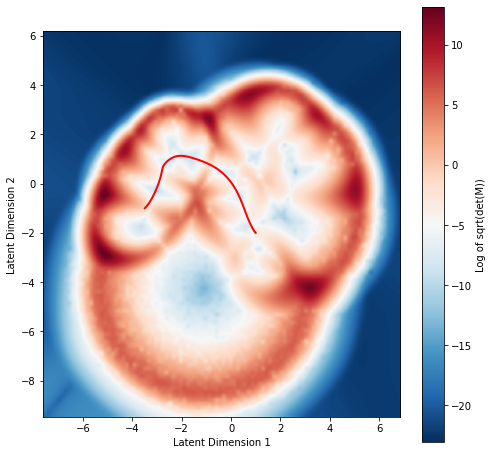

construct solver graph
[Initialize Graph] [Processed point: 0/64]
Compute geodesic


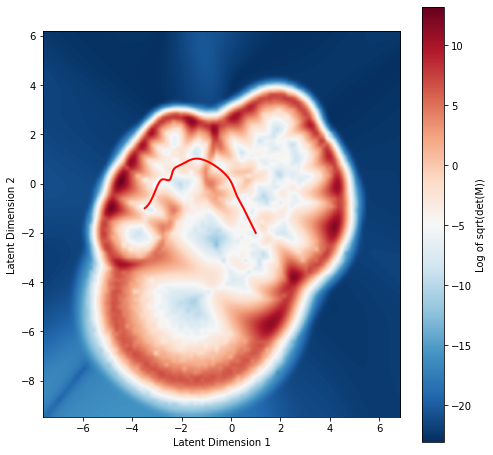

construct solver graph
[Initialize Graph] [Processed point: 0/64]
Compute geodesic


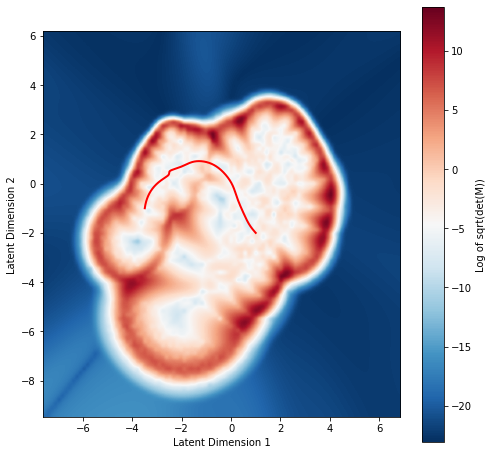

construct solver graph
[Initialize Graph] [Processed point: 0/64]
Compute geodesic


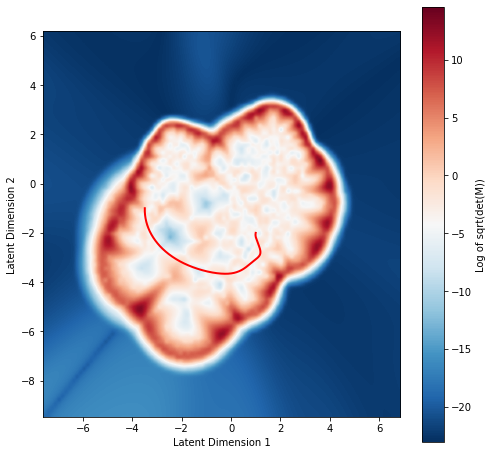

construct solver graph
[Initialize Graph] [Processed point: 0/64]
Compute geodesic


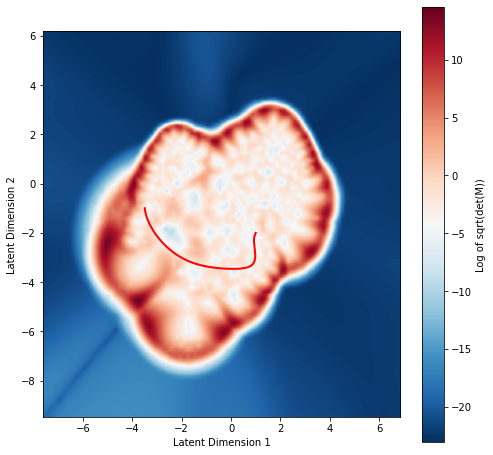

In [9]:
#for a in [0.25,0.5,1,1.25,2,3]:
from core import riemannian_metric
from core import custom_geodesics
for k_rbf in [16,32,64,96,128]:
    # load the saved model
    input_dim = train_dataset[0][0].shape[-1]
    hidden_dims = [64, 32]
    latent_dim = 2
    hidden_activation = nn.Tanh()
    encoder_output_mu_activation=nn.Identity()
    encoder_output_logvar_activation=nn.Softplus()
    decoder_output_mu_activation=nn.Sigmoid()
    decoder_output_logvar_activation=nn.Softplus()

    model_VAE = VAE.VAE(input_dim = input_dim, 
                    hidden_dims = hidden_dims,
                    latent_dim = latent_dim, 
                    hidden_activation=hidden_activation, 
                    encoder_output_mu_activation=encoder_output_mu_activation,
                    encoder_output_logvar_activation=encoder_output_logvar_activation,
                    decoder_output_mu_activation=decoder_output_mu_activation,
                    decoder_output_logvar_activation=decoder_output_logvar_activation)

    # create RBF network
    a = 1.25
    zeta_rbf = 1e-6
    model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

    # create VAE-RBF model
    model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)
    model_VAE_RBF.load_state_dict(torch.load(f'model_figures/vaerbf_k={k_rbf}.pt'))

    # encode and decode the data and store the outputs of the model
    # computed on the whole dataset
    latent_means_list = []
    latent_logvars_list = []
    latent_z = []
    output_means_list = []
    output_logvars_list = []
    labels_list = []

    with torch.no_grad():  
        for imgs, labels_ in train_loader: 
            mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
            z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
            latent_means_list.append(mu_z)
            latent_logvars_list.append(log_var_z)
            latent_z.append(z_rep)
            output_means_list.append(mu_x)
            output_logvars_list.append(log_var_x)
            labels_list.append(labels_)

    # Now we concatenate the list to form a single Tensor
    latent_means = torch.cat(latent_means_list, dim=0)
    latent_logvars = torch.cat(latent_logvars_list, dim=0)
    latent_z = torch.cat(latent_z, dim=0)
    output_means = torch.cat(output_means_list, dim=0)
    output_logvars = torch.cat(output_logvars_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    
    metric = riemannian_metric.Riemannian_metric(model_VAE_RBF)
    #M_z = metric.compute_riemannian_metric(latent_means,var_rbfn=True).detach().numpy()

    latent_means_np = latent_means.detach().numpy()

    print("construct solver graph")
    GRAPH_DATA = KMeans(n_clusters=64, n_init=30, max_iter=1000).fit(latent_means_np).cluster_centers_
    solver_graph = custom_geodesics.SolverGraph(metric, data=GRAPH_DATA, kNN_num=5, tol=1e-2)

    c0 = np.array([[-3.5], [-1.]])
    c1 = np.array([[1.], [-2.]])
    
    print("Compute geodesic")
    # compute geodesic
    curve_graph, logmap_graph, curve_length_graph, failed_graph, solution_graph \
    = custom_geodesics.solver_graph(solver_graph, metric, c0, c1)
 
    # plot measure on latent space
    latent_means_np = latent_means.detach().numpy()
    z1min, z2min = latent_means_np.min(0) - 0.5
    z1max, z2max = latent_means_np.max(0) + 0.5
    fig, ax = plt.subplots(figsize=(8, 8))
    offset=3

    metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 100),vae_rbfn=True)

    T = np.linspace(0, 1, 1000)
    curve_eval = curve_graph(T)[0]
    plt.plot(curve_eval[0, :], curve_eval[1, :],c='r', linewidth=2, label = 'Geodesic curve')
    
    plt.show()
    fig.savefig(f'model_figures/geodesics_k={k_rbf}.png')


construct solver graph
[Initialize Graph] [Processed point: 0/64]
Compute geodesic


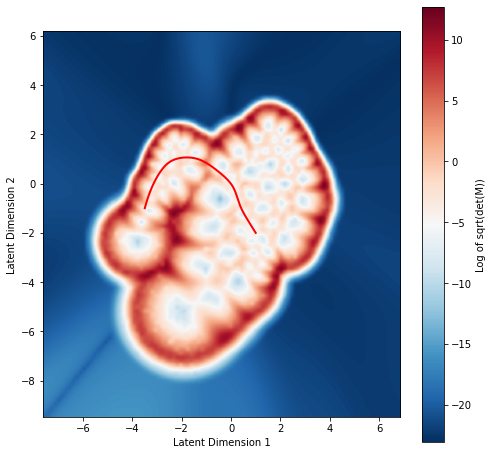

In [12]:
#for a in [0.25,0.5,1,1.25,2,3]:
from core import riemannian_metric
from core import custom_geodesics
for a in [1]:
    # load the saved model
    input_dim = train_dataset[0][0].shape[-1]
    hidden_dims = [64, 32]
    latent_dim = 2
    hidden_activation = nn.Tanh()
    encoder_output_mu_activation=nn.Identity()
    encoder_output_logvar_activation=nn.Softplus()
    decoder_output_mu_activation=nn.Sigmoid()
    decoder_output_logvar_activation=nn.Softplus()

    model_VAE = VAE.VAE(input_dim = input_dim, 
                    hidden_dims = hidden_dims,
                    latent_dim = latent_dim, 
                    hidden_activation=hidden_activation, 
                    encoder_output_mu_activation=encoder_output_mu_activation,
                    encoder_output_logvar_activation=encoder_output_logvar_activation,
                    decoder_output_mu_activation=decoder_output_mu_activation,
                    decoder_output_logvar_activation=decoder_output_logvar_activation)

    # create RBF network
    k_rbf = 64
    zeta_rbf = 1e-6
    model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

    # create VAE-RBF model
    model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)
    model_VAE_RBF.load_state_dict(torch.load(f'model_figures/vaerbf_a={a}.pt'))

    # encode and decode the data and store the outputs of the model
    # computed on the whole dataset
    latent_means_list = []
    latent_logvars_list = []
    latent_z = []
    output_means_list = []
    output_logvars_list = []
    labels_list = []

    with torch.no_grad():  
        for imgs, labels_ in train_loader: 
            mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
            z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
            latent_means_list.append(mu_z)
            latent_logvars_list.append(log_var_z)
            latent_z.append(z_rep)
            output_means_list.append(mu_x)
            output_logvars_list.append(log_var_x)
            labels_list.append(labels_)

    # Now we concatenate the list to form a single Tensor
    latent_means = torch.cat(latent_means_list, dim=0)
    latent_logvars = torch.cat(latent_logvars_list, dim=0)
    latent_z = torch.cat(latent_z, dim=0)
    output_means = torch.cat(output_means_list, dim=0)
    output_logvars = torch.cat(output_logvars_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    
    metric = riemannian_metric.Riemannian_metric(model_VAE_RBF)
    #M_z = metric.compute_riemannian_metric(latent_means,var_rbfn=True).detach().numpy()

    latent_means_np = latent_means.detach().numpy()

    print("construct solver graph")
    GRAPH_DATA = KMeans(n_clusters=64, n_init=30, max_iter=1000).fit(latent_means_np).cluster_centers_
    solver_graph = custom_geodesics.SolverGraph(metric, data=GRAPH_DATA, kNN_num=5, tol=1e-2)

    c0 = np.array([[-3.5], [-1.]])
    c1 = np.array([[1.], [-2.]])
    
    print("Compute geodesic")
    # compute geodesic
    curve_graph, logmap_graph, curve_length_graph, failed_graph, solution_graph \
    = custom_geodesics.solver_graph(solver_graph, metric, c0, c1)
 
    # plot measure on latent space
    latent_means_np = latent_means.detach().numpy()
    z1min, z2min = latent_means_np.min(0) - 0.5
    z1max, z2max = latent_means_np.max(0) + 0.5
    fig, ax = plt.subplots(figsize=(8, 8))
    offset=3

    metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 100),vae_rbfn=True)

    T = np.linspace(0, 1, 1000)
    curve_eval = curve_graph(T)[0]
    plt.plot(curve_eval[0, :], curve_eval[1, :],c='r', linewidth=2, label = 'Geodesic curve')
    
    plt.show()
    fig.savefig(f'model_figures/geodesics_a={a}.png')


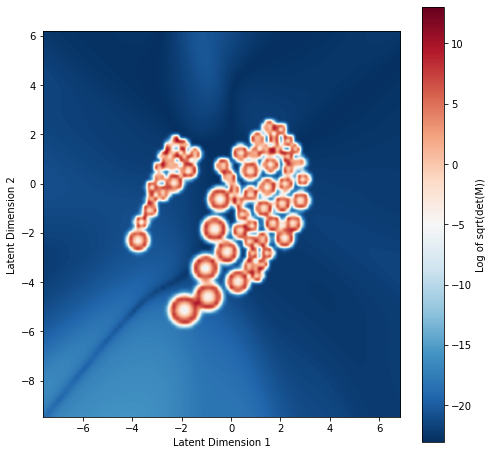

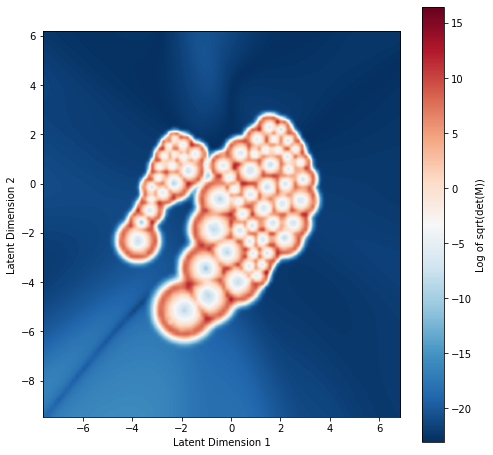

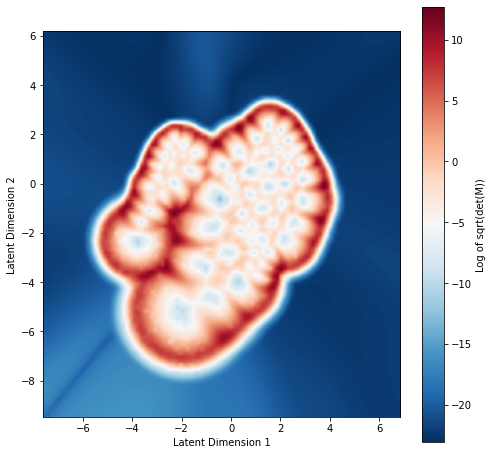

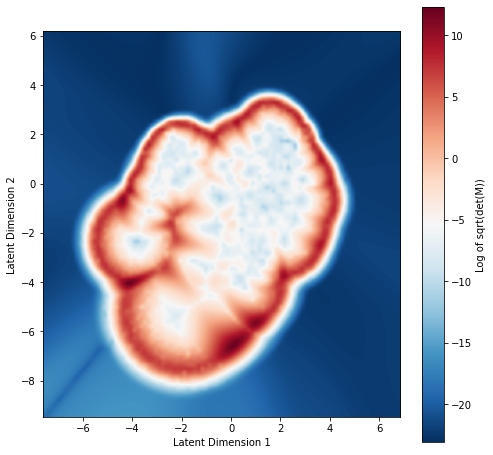

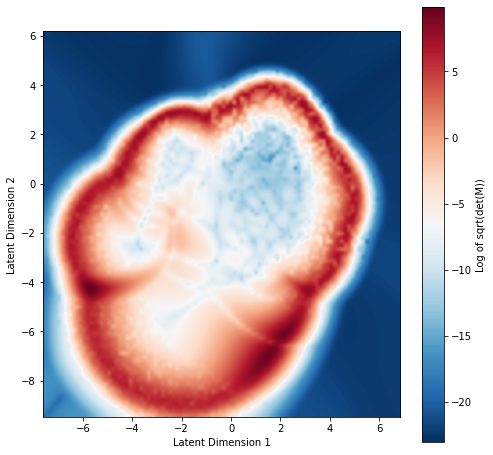

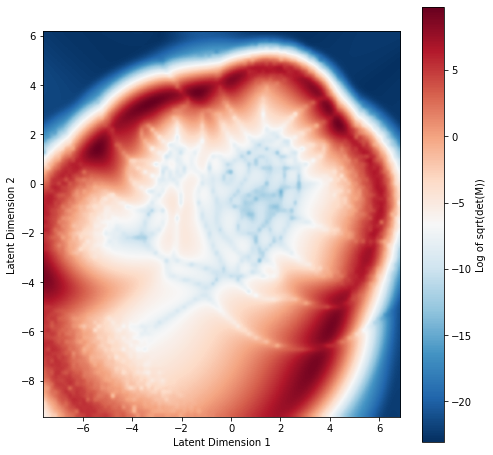

In [6]:
#for k_rbf in [16,32,64,96,128]:
for a in [0.25,0.5,1,1.25,2,3]:
    # load the saved model
    input_dim = train_dataset[0][0].shape[-1]
    hidden_dims = [64, 32]
    latent_dim = 2
    hidden_activation = nn.Tanh()
    encoder_output_mu_activation=nn.Identity()
    encoder_output_logvar_activation=nn.Softplus()
    decoder_output_mu_activation=nn.Sigmoid()
    decoder_output_logvar_activation=nn.Softplus()

    model_VAE = VAE.VAE(input_dim = input_dim, 
                    hidden_dims = hidden_dims,
                    latent_dim = latent_dim, 
                    hidden_activation=hidden_activation, 
                    encoder_output_mu_activation=encoder_output_mu_activation,
                    encoder_output_logvar_activation=encoder_output_logvar_activation,
                    decoder_output_mu_activation=decoder_output_mu_activation,
                    decoder_output_logvar_activation=decoder_output_logvar_activation)

    # create RBF network
    k_rbf = 64
    zeta_rbf = 1e-6
    model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

    # create VAE-RBF model
    model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)
    model_VAE_RBF.load_state_dict(torch.load(f'model_figures/vaerbf_a={a}.pt'))

    # encode and decode the data and store the outputs of the model
    # computed on the whole dataset
    latent_means_list = []
    latent_logvars_list = []
    latent_z = []
    output_means_list = []
    output_logvars_list = []
    labels_list = []

    with torch.no_grad():  
        for imgs, labels_ in train_loader: 
            mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
            z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
            latent_means_list.append(mu_z)
            latent_logvars_list.append(log_var_z)
            latent_z.append(z_rep)
            output_means_list.append(mu_x)
            output_logvars_list.append(log_var_x)
            labels_list.append(labels_)

    # Now we concatenate the list to form a single Tensor
    latent_means = torch.cat(latent_means_list, dim=0)
    latent_logvars = torch.cat(latent_logvars_list, dim=0)
    latent_z = torch.cat(latent_z, dim=0)
    output_means = torch.cat(output_means_list, dim=0)
    output_logvars = torch.cat(output_logvars_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    
    metric = riemannian_metric.Riemannian_metric(model_VAE_RBF)

    # plot measure on latent space
    latent_means_np = latent_means.detach().numpy()
    z1min, z2min = latent_means_np.min(0) - 0.5
    z1max, z2max = latent_means_np.max(0) + 0.5
    fig, ax = plt.subplots(figsize=(8, 8))
    offset=3

    metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 100),vae_rbfn=True)
    plt.show()
    fig.savefig(f'model_figures/metric,a={a},k=64.png')

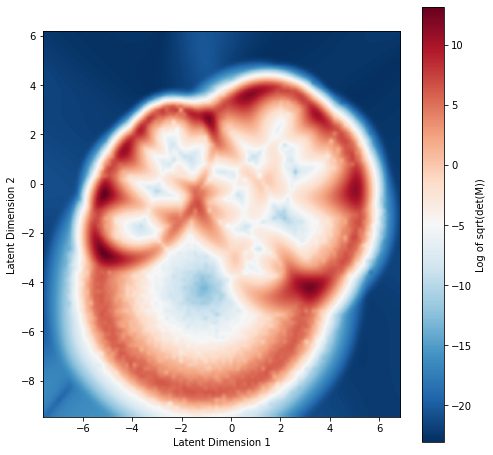

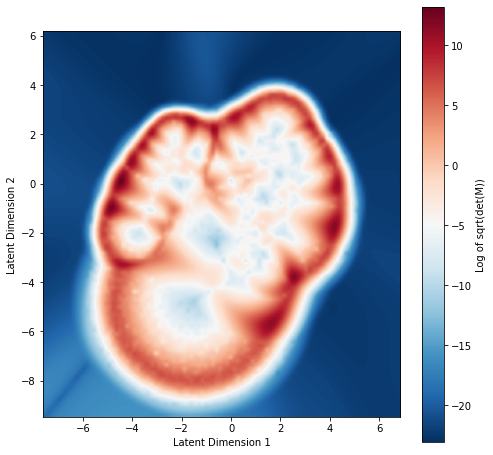

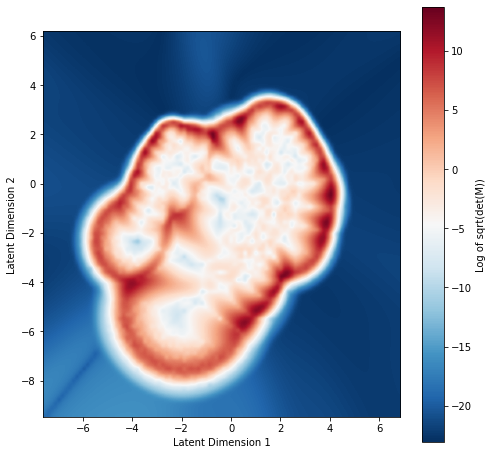

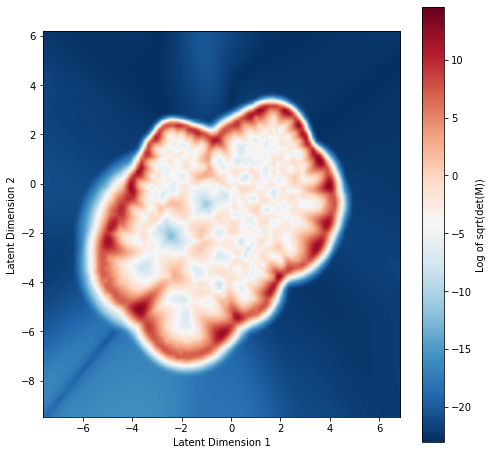

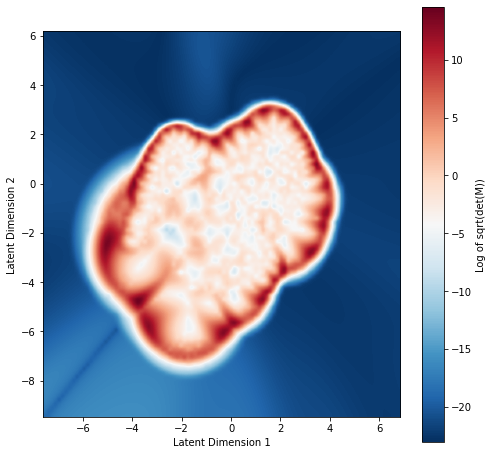

In [8]:
for k_rbf in [16,32,64,96,128]:
#for a in [0.25,0.5,1,1.25,2,3]:
    # load the saved model
    input_dim = train_dataset[0][0].shape[-1]
    hidden_dims = [64, 32]
    latent_dim = 2
    hidden_activation = nn.Tanh()
    encoder_output_mu_activation=nn.Identity()
    encoder_output_logvar_activation=nn.Softplus()
    decoder_output_mu_activation=nn.Sigmoid()
    decoder_output_logvar_activation=nn.Softplus()

    model_VAE = VAE.VAE(input_dim = input_dim, 
                    hidden_dims = hidden_dims,
                    latent_dim = latent_dim, 
                    hidden_activation=hidden_activation, 
                    encoder_output_mu_activation=encoder_output_mu_activation,
                    encoder_output_logvar_activation=encoder_output_logvar_activation,
                    decoder_output_mu_activation=decoder_output_mu_activation,
                    decoder_output_logvar_activation=decoder_output_logvar_activation)

    # create RBF network
    a = 1.25
    zeta_rbf = 1e-6
    model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

    # create VAE-RBF model
    model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)
    model_VAE_RBF.load_state_dict(torch.load(f'model_figures/vaerbf_k={k_rbf}.pt'))

    # encode and decode the data and store the outputs of the model
    # computed on the whole dataset
    latent_means_list = []
    latent_logvars_list = []
    latent_z = []
    output_means_list = []
    output_logvars_list = []
    labels_list = []

    with torch.no_grad():  
        for imgs, labels_ in train_loader: 
            mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
            z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
            latent_means_list.append(mu_z)
            latent_logvars_list.append(log_var_z)
            latent_z.append(z_rep)
            output_means_list.append(mu_x)
            output_logvars_list.append(log_var_x)
            labels_list.append(labels_)

    # Now we concatenate the list to form a single Tensor
    latent_means = torch.cat(latent_means_list, dim=0)
    latent_logvars = torch.cat(latent_logvars_list, dim=0)
    latent_z = torch.cat(latent_z, dim=0)
    output_means = torch.cat(output_means_list, dim=0)
    output_logvars = torch.cat(output_logvars_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    
    metric = riemannian_metric.Riemannian_metric(model_VAE_RBF)

    # plot measure on latent space
    latent_means_np = latent_means.detach().numpy()
    z1min, z2min = latent_means_np.min(0) - 0.5
    z1max, z2max = latent_means_np.max(0) + 0.5
    fig, ax = plt.subplots(figsize=(8, 8))
    offset=3

    metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 100),vae_rbfn=True)
    plt.show()
    fig.savefig(f'model_figures/metric,a={a},k={k_rbf}.png')

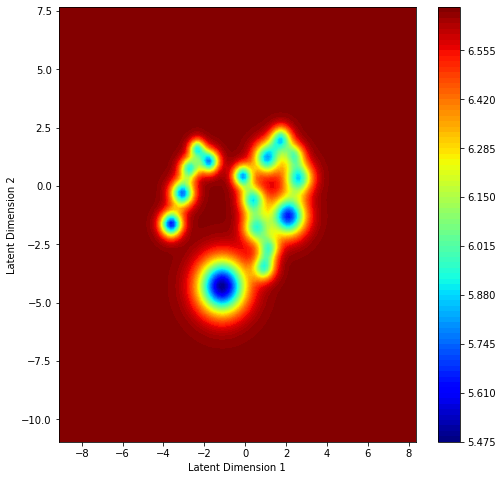

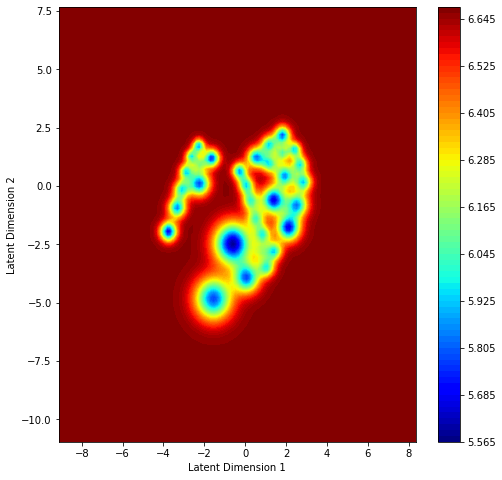

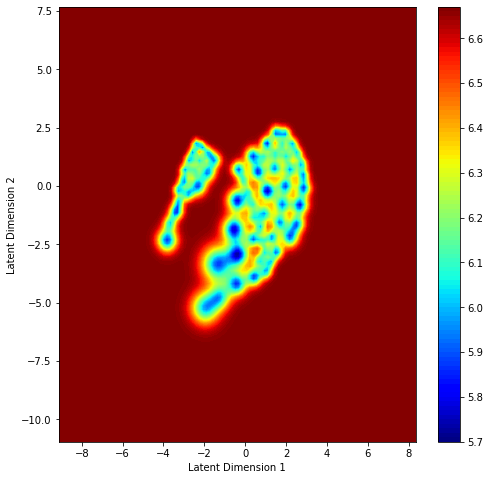

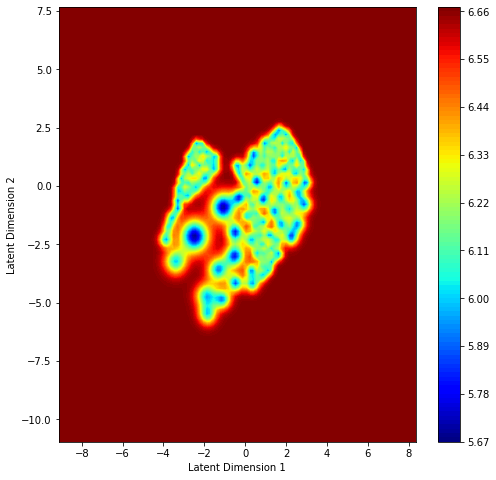

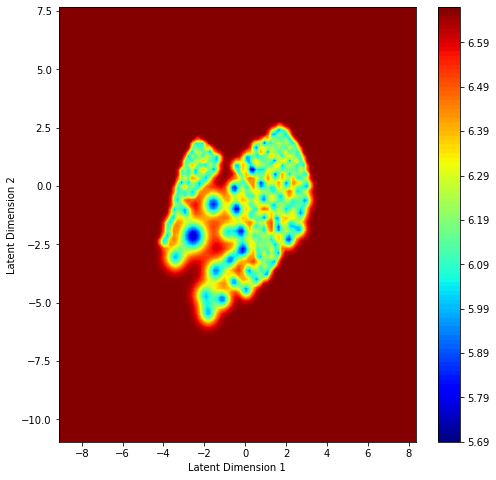

In [19]:
for k_rbf in [16,32,64,96,128]:
#for a in [0.25,0.5,1,1.25,2,3]:
    # load the saved model
    input_dim = train_dataset[0][0].shape[-1]
    hidden_dims = [64, 32]
    latent_dim = 2
    hidden_activation = nn.Tanh()
    encoder_output_mu_activation=nn.Identity()
    encoder_output_logvar_activation=nn.Softplus()
    decoder_output_mu_activation=nn.Sigmoid()
    decoder_output_logvar_activation=nn.Softplus()

    model_VAE = VAE.VAE(input_dim = input_dim, 
                    hidden_dims = hidden_dims,
                    latent_dim = latent_dim, 
                    hidden_activation=hidden_activation, 
                    encoder_output_mu_activation=encoder_output_mu_activation,
                    encoder_output_logvar_activation=encoder_output_logvar_activation,
                    decoder_output_mu_activation=decoder_output_mu_activation,
                    decoder_output_logvar_activation=decoder_output_logvar_activation)

    # create RBF network
    a = 1.25
    zeta_rbf = 1e-6
    model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

    # create VAE-RBF model
    model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)
    model_VAE_RBF.load_state_dict(torch.load(f'model_figures/vaerbf_k={k_rbf}.pt'))

    # encode and decode the data and store the outputs of the model
    # computed on the whole dataset
    latent_means_list = []
    latent_logvars_list = []
    latent_z = []
    output_means_list = []
    output_logvars_list = []
    labels_list = []

    with torch.no_grad():  
        for imgs, labels_ in train_loader: 
            mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
            z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
            latent_means_list.append(mu_z)
            latent_logvars_list.append(log_var_z)
            latent_z.append(z_rep)
            output_means_list.append(mu_x)
            output_logvars_list.append(log_var_x)
            labels_list.append(labels_)

    # Now we concatenate the list to form a single Tensor
    latent_means = torch.cat(latent_means_list, dim=0)
    latent_logvars = torch.cat(latent_logvars_list, dim=0)
    latent_z = torch.cat(latent_z, dim=0)
    output_means = torch.cat(output_means_list, dim=0)
    output_logvars = torch.cat(output_logvars_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    
    max_x = latent_means.max(dim=0).values[0]
    max_y = latent_means.max(dim=0).values[1]
    min_x = latent_means.min(dim=0).values[0]
    min_y = latent_means.min(dim=0).values[1]

    # plot the latent space
    n=100
    offset=5
    x = torch.linspace(min_x-offset,max_x+offset,n)
    y = torch.linspace(min_y-offset,max_y+offset,n)
    X,Y = torch.meshgrid(x,y)
    grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

    with torch.no_grad():
        logvar_x = model_VAE_RBF.RBF(grid)
        #summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
        summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
        summed_logvar_x = summed_logvar_x.reshape(X.shape)
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
        plt.colorbar()
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        #plt.title('Log of summed std')
        plt.show()
    
    fig.savefig(f'model_figures/logsumsigma,k={k_rbf}.png')

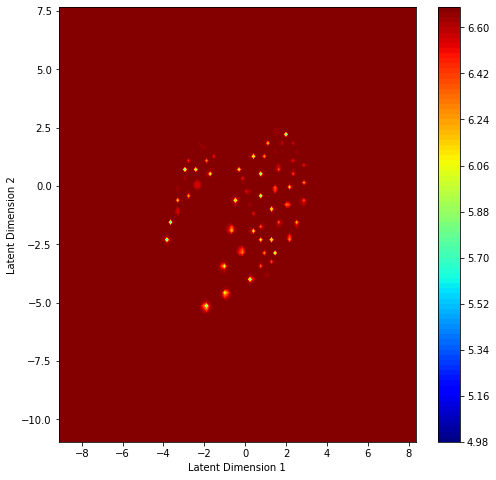

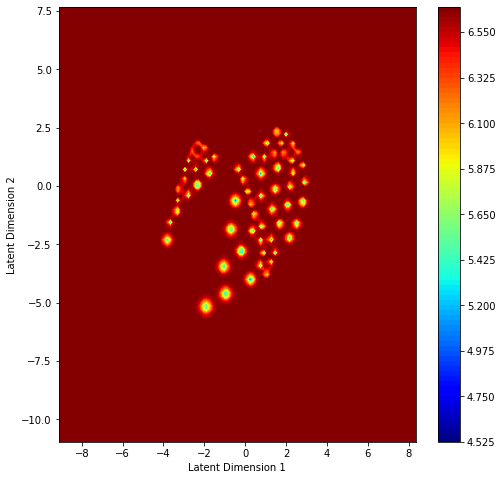

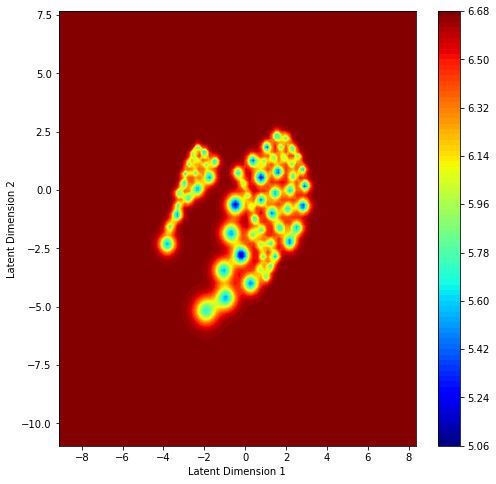

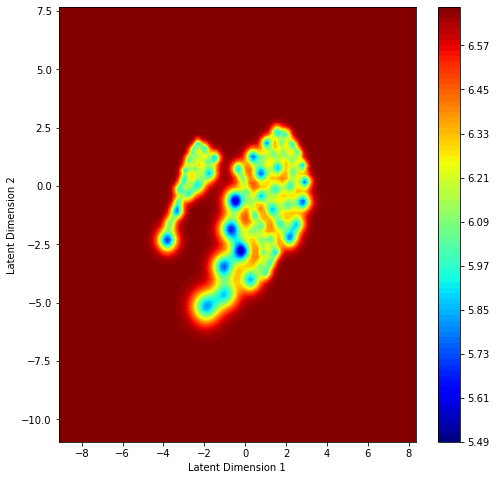

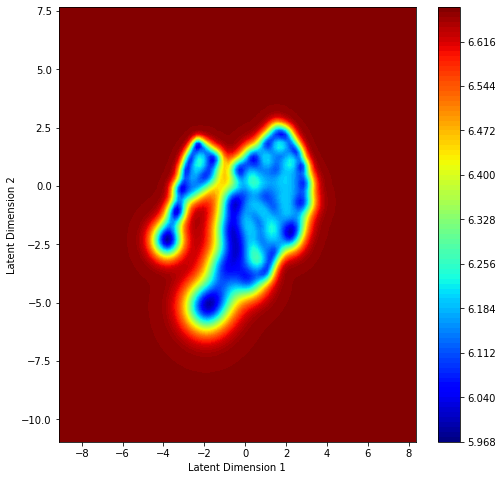

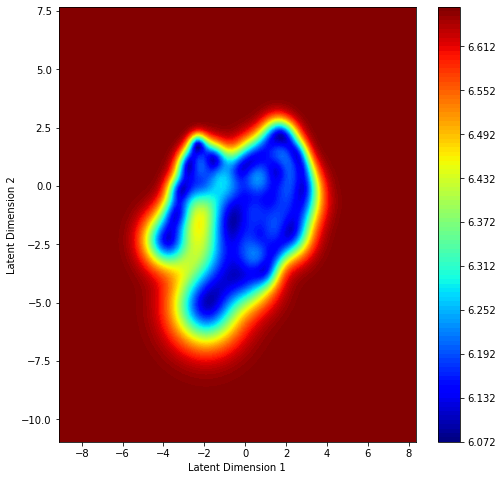

In [20]:
#for k_rbf in [16,32,64,96,128]:
for a in [0.25,0.5,1,1.25,2,3]:
    # load the saved model
    input_dim = train_dataset[0][0].shape[-1]
    hidden_dims = [64, 32]
    latent_dim = 2
    hidden_activation = nn.Tanh()
    encoder_output_mu_activation=nn.Identity()
    encoder_output_logvar_activation=nn.Softplus()
    decoder_output_mu_activation=nn.Sigmoid()
    decoder_output_logvar_activation=nn.Softplus()

    model_VAE = VAE.VAE(input_dim = input_dim, 
                    hidden_dims = hidden_dims,
                    latent_dim = latent_dim, 
                    hidden_activation=hidden_activation, 
                    encoder_output_mu_activation=encoder_output_mu_activation,
                    encoder_output_logvar_activation=encoder_output_logvar_activation,
                    decoder_output_mu_activation=decoder_output_mu_activation,
                    decoder_output_logvar_activation=decoder_output_logvar_activation)

    # create RBF network
    k_rbf = 64
    zeta_rbf = 1e-6
    model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

    # create VAE-RBF model
    model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)
    model_VAE_RBF.load_state_dict(torch.load(f'model_figures/vaerbf_a={a}.pt'))

    # encode and decode the data and store the outputs of the model
    # computed on the whole dataset
    latent_means_list = []
    latent_logvars_list = []
    latent_z = []
    output_means_list = []
    output_logvars_list = []
    labels_list = []

    with torch.no_grad():  
        for imgs, labels_ in train_loader: 
            mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
            z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
            latent_means_list.append(mu_z)
            latent_logvars_list.append(log_var_z)
            latent_z.append(z_rep)
            output_means_list.append(mu_x)
            output_logvars_list.append(log_var_x)
            labels_list.append(labels_)

    # Now we concatenate the list to form a single Tensor
    latent_means = torch.cat(latent_means_list, dim=0)
    latent_logvars = torch.cat(latent_logvars_list, dim=0)
    latent_z = torch.cat(latent_z, dim=0)
    output_means = torch.cat(output_means_list, dim=0)
    output_logvars = torch.cat(output_logvars_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    
    max_x = latent_means.max(dim=0).values[0]
    max_y = latent_means.max(dim=0).values[1]
    min_x = latent_means.min(dim=0).values[0]
    min_y = latent_means.min(dim=0).values[1]

    # plot the latent space
    n=100
    offset=5
    x = torch.linspace(min_x-offset,max_x+offset,n)
    y = torch.linspace(min_y-offset,max_y+offset,n)
    X,Y = torch.meshgrid(x,y)
    grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

    with torch.no_grad():
        logvar_x = model_VAE_RBF.RBF(grid)
        #summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
        summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
        summed_logvar_x = summed_logvar_x.reshape(X.shape)
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
        plt.colorbar()
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        #plt.title('Log of summed std')
        plt.show()
    
    fig.savefig(f'model_figures/logsumsigma,a={a}.png')